# CNN w/ Keras on TF
## We add data augmentation

The first model in our original comparison is based on the work of [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6). His kernel highlights the importance of data augmentation -- he was able to increase his accuracy from 98.114% to 99.67% with the help of datauagmentation.

We see if we can do better. Without data augmentation, 30 epochs of training got us the following validation accuracy scores
- 99.19% with the architecture of [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
- 99.00% with the architecture of [somshubramajumdar](https://www.kaggle.com/somshubramajumdar/deep-convolutional-network-using-keras)
- 99.19% with the architecture of [yashk2810.github]( https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/)
- 99.02% with BatchNormalization added to the architecture of [somshubramajumdar](https://www.kaggle.com/somshubramajumdar/deep-convolutional-network-using-keras)

Adata augmentation should help with the overfitting we saw exhibited by Models 2-4 (diverging Train & Valid Accuracy). 

# Set up

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy import stats
import cPickle as pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.utils import to_categorical # For keras > 2.0
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#for model3
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation

# Data Preprocessing

In [34]:
train = pd.read_csv("~/.kaggle/competitions/digit-recognizer/train.csv")
test = pd.read_csv("~/.kaggle/competitions/digit-recognizer/test.csv")

In [35]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

del train 

*"Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive."*

In [36]:
print(Y_train.shape)
print(X_train.shape)

(42000,)
(42000, 784)


In [37]:
print(X_train.min().min())
print(X_train.max().max())
# print(X_train.shape)

0
255


We reshape the data from pandas.Dataframes of 1D vectors of 784 values to 3D (28x28x1) matrices. The 3rd dim is req'd by Keras, corresponding to channels. Since MNIST images are gray scaled, so it uses only one channel (as opposed to RGB images having 3 channels). 

In [38]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

We encode Y_train (training labels) to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [39]:
print(Y_train.shape)
print(Y_train.describe())
print(np.array(Y_train.head()))

(42000,)
count    42000.000000
mean         4.456643
std          2.887730
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64
[1 0 1 4 0]


In [40]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [41]:
print(Y_train.shape)
print(pd.DataFrame(Y_train).describe())

(42000, 10)
                  0             1             2             3             4  \
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000   
mean       0.098381      0.111524      0.099452      0.103595      0.096952   
std        0.297833      0.314783      0.299272      0.304738      0.295896   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  5             6             7             8             9  
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000  
mean       0.090357      0.098500      0.104786      0.096738      0.099714  
std        0.286696      0.297993      0.3

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

We split training and valdiation set 

In [42]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

We can get a better sense for one of these examples by visualising the image and looking at the label.

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


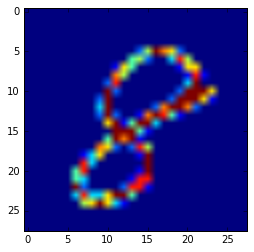

In [43]:
print(Y_train[0])
plt.imshow(X_train[0][:,:,0])

# Define the Data Augmentation


Based on [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6):

- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- No vertical_flip or horizontal_flip 


In [98]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Define the CNN models
We start by comparing three different model architectures, all sharing some common attributes

In [45]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 86

img_rows, img_cols = 28, 28

nb_filters_1 = 32 
nb_filters_2 = 64 
nb_filters_3 = 128 

nb_conv = 3 # kernel_size dim
nb_classes = Y_train.shape[1]


## CNN Model #1:
Based on [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6). 

**Layer 1, 2, 5, 6:** convolutional (Conv2D) layer with nb_filters_1 (32) filters for 1&2 and nb_filters_2 (64) filters for 5&6. Each filter transforms a part of the image defined by the kernel size nb_conv (3) using the kernel filter. 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

**Layer 3, 7:** Each sequence of two convolution (Conv2D) layers os followed by the pooling (MaxPool2D) layer, which acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value (reduce computational cost, reduce overfitting). 

*Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.*

**Layer 4, 8, 11:** Each pooling layer is followed by dropout (Dropout), is a regularization method in which a random proportion of the nodes in a layer are randomly ignored by setting their wieghts to zero. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

**Layer 9:** The Flatten layer converts the final feature maps into a one single 1D vector. It combines all the found local features of the previous convolutional layers and makes it possible to use of fully connected layers after the convolutional/maxpool layers. 

**Layer 10, 12:** Finally, two fully-connected (Dense) layers which are just artificial an neural networks (ANN) classifiers. In the last layer(Dense(10,activation="softmax")), the net outputs distribution of probability of each class.

In [46]:
model1 = Sequential()
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(nb_classes, activation = "softmax"))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
__________

In [49]:
# Define the optimizer & Compile the model
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model1.compile(optimizer = optimizer , \
              loss = "categorical_crossentropy", \
              metrics=["accuracy"])

# Train Model & Pickle the Training History
history1 = model1.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),\
                                epochs = epochs, validation_data = (X_val,Y_val),\
                                verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,\
                                callbacks=[learning_rate_reduction])

Epoch 1/30
 - 37s - loss: 0.7526 - acc: 0.8261 - val_loss: 0.0723 - val_acc: 0.9788
Epoch 2/30
 - 35s - loss: 0.1610 - acc: 0.9525 - val_loss: 0.1185 - val_acc: 0.9638
Epoch 3/30
 - 36s - loss: 0.1238 - acc: 0.9631 - val_loss: 0.0574 - val_acc: 0.9838
Epoch 4/30
 - 36s - loss: 0.1112 - acc: 0.9680 - val_loss: 0.0438 - val_acc: 0.9874
Epoch 5/30
 - 35s - loss: 0.1038 - acc: 0.9709 - val_loss: 0.0333 - val_acc: 0.9898
Epoch 6/30
 - 36s - loss: 0.0985 - acc: 0.9725 - val_loss: 0.0308 - val_acc: 0.9898
Epoch 7/30
 - 36s - loss: 0.0974 - acc: 0.9734 - val_loss: 0.0342 - val_acc: 0.9895
Epoch 8/30
 - 36s - loss: 0.0960 - acc: 0.9745 - val_loss: 0.0365 - val_acc: 0.9900
Epoch 9/30
 - 36s - loss: 0.0988 - acc: 0.9732 - val_loss: 0.0316 - val_acc: 0.9902
Epoch 10/30
 - 36s - loss: 0.1007 - acc: 0.9730 - val_loss: 0.0499 - val_acc: 0.9850
Epoch 11/30
 - 35s - loss: 0.1044 - acc: 0.9726 - val_loss: 0.0384 - val_acc: 0.9890
Epoch 12/30
 - 36s - loss: 0.1055 - acc: 0.9729 - val_loss: 0.0529 - val_a

In [55]:
# with open('model1_history_30epochs_wDAug.p', 'wb') as file_pi:
#     pickle.dump(history1.history, file_pi)

In [64]:
history1_wDaug = pickle.load( open( 'model1_history_30epochs_wDAug.p', 'rb'))
history1_noLRed = pickle.load( open( 'model1_history_30epochs_noLRred.p', 'rb'))
history1 = pickle.load( open( 'model1_history_30epochs.p', 'rb'))

In [ ]:
# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.98)

plt.plot(history1['acc'], color='firebrick', linestyle='--', label="Train Acc")
plt.plot(history1['val_acc'], color='firebrick',label="Valid Acc")

plt.plot(history1_wDaug['acc'], color='mediumturquoise', linestyle='--', label="Augmented Train Acc")
plt.plot(history1_wDaug['val_acc'], color='mediumturquoise',label="Augmented Valid Acc")

plt.plot(history1_noLRed['acc'], color='b', linestyle='--', label="noLReduction Train Acc")
plt.plot(history1_noLRed['val_acc'], color='b',label="noLReduction Valid Acc")

plt.title("Model 1 CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=2)

## CNN Model #2:
Based on [somshubramajumdar](https://www.kaggle.com/somshubramajumdar/deep-convolutional-network-using-keras). 

Same as Model #1 except we drop (!) both of the Dropout layers following the first and second set of Conv2D+Conv2D+MaxPool2D. Thefinal sequence of Flatten+Dense+Dropout+Dense is replaced by Flatten+Dropout+Dense+Dense. The second to last Dense layer's ouput space dim is half that of Model#1 (128 vesus 256). Also, adam is used as the update rule instead of RMSProp.

Comparing the accuracy of these two models, model 2 exhibits more overfitting but ultimately performs just as well as model 1. 

**Without data augmentation: After 30 epochs:** val_acc: 0.9900

[*"in CNN, usually, a Dropout layer is applied after each pooling layer, and also after your Dense layer. A good tutorial is here"*](https://datascience.stackexchange.com/questions/22760/number-and-size-of-dense-layers-in-a-cnn)

In [22]:
model2 = Sequential()

model2.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model2.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(strides=(2,2)))

model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(128, activation = "relu"))
model2.add(Dense(nb_classes, activation = "softmax"))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
__________

In [66]:
# Define the optimizer & Compile the model
optimizer = "adam"
model2.compile(optimizer = optimizer , \
              loss = "categorical_crossentropy", \
              metrics=["accuracy"])

# Train Model & Pickle the Training History
history2 = model2.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),\
                                epochs = epochs, validation_data = (X_val,Y_val),\
                                verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,\
                                callbacks=[learning_rate_reduction])



Epoch 1/30
 - 41s - loss: 0.0996 - acc: 0.9706 - val_loss: 0.0340 - val_acc: 0.9898
Epoch 2/30
 - 39s - loss: 0.0550 - acc: 0.9838 - val_loss: 0.0333 - val_acc: 0.9914
Epoch 3/30
 - 39s - loss: 0.0466 - acc: 0.9863 - val_loss: 0.0330 - val_acc: 0.9912
Epoch 4/30
 - 40s - loss: 0.0399 - acc: 0.9877 - val_loss: 0.0289 - val_acc: 0.9929
Epoch 5/30
 - 40s - loss: 0.0374 - acc: 0.9884 - val_loss: 0.0291 - val_acc: 0.9926
Epoch 6/30
 - 40s - loss: 0.0350 - acc: 0.9894 - val_loss: 0.0247 - val_acc: 0.9933
Epoch 7/30
 - 40s - loss: 0.0339 - acc: 0.9896 - val_loss: 0.0284 - val_acc: 0.9929
Epoch 8/30
 - 40s - loss: 0.0342 - acc: 0.9891 - val_loss: 0.0288 - val_acc: 0.9929
Epoch 9/30
 - 40s - loss: 0.0288 - acc: 0.9912 - val_loss: 0.0220 - val_acc: 0.9931

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 10/30
 - 40s - loss: 0.0228 - acc: 0.9930 - val_loss: 0.0270 - val_acc: 0.9933
Epoch 11/30
 - 40s - loss: 0.0201 - acc: 0.9938 - val_loss: 0.0253 - val_acc: 0.99

In [68]:
with open('model2_history_30epochs_wDAug.p', 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)

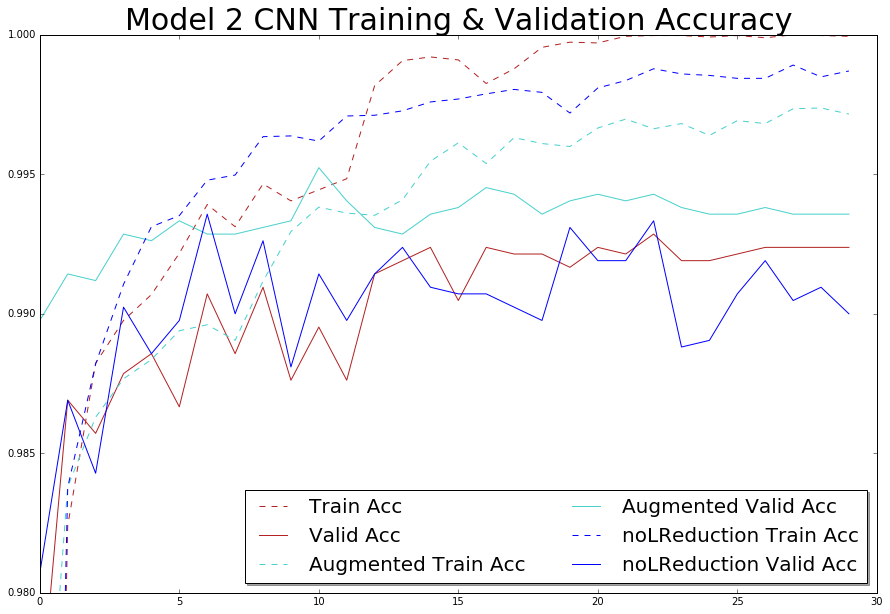

In [82]:
history2_wDaug = pickle.load( open( 'model2_history_30epochs_wDAug.p', 'rb'))
history2_noLRed = pickle.load( open( 'model2_history_30epochs_noLRred.p', 'rb'))
history2 = pickle.load( open( 'model2_history_30epochs.p', 'rb'))

# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.98)

plt.plot(history2['acc'], color='firebrick', linestyle='--', label="Train Acc")
plt.plot(history2['val_acc'], color='firebrick',label="Valid Acc")

plt.plot(history2_wDaug['acc'], color='mediumturquoise', linestyle='--', label="Augmented Train Acc")
plt.plot(history2_wDaug['val_acc'], color='mediumturquoise',label="Augmented Valid Acc")

plt.plot(history2_noLRed['acc'], color='b', linestyle='--', label="noLReduction Train Acc")
plt.plot(history2_noLRed['val_acc'], color='b',label="noLReduction Valid Acc")

plt.title("Model 2 CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=2)

## CNN Model #3:
Based on [yashk2810.github]( https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/). 

A completely different architecture! We keep our individual **Conv2D** layers the same in terms of filters and kernel size values, but now instead for the padding parameter being 'Same', it is set to the default 'Valid'. Lastly, activation in these layers is set to the default of None, and only implemented after Batch Normalization. 

No longer are we stringing two Conv2D layers together. Instead, each Conv2D layer is followed by BatchNormalization and Activation, for a total of 4 sequences of Conv2D+BatchNormalization+Activation. 

**BatchNormalization**: performs normalization for each training mini-batch, allowing us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout. 

**Activation**: In previous models, this was incorporated intp the Conv2D layer but now, we save this for after BatchNormalization. It is debatable whether Activation should precede or follow BatchNormalization. 

After ever 2 sequences of Conv2D+BatchNormalization+Activation, we follow with a MaxPool2D of the same size as in the previous two models.

Finally, we wrap up with a sequence of Flatten+Dense+BatchNormalization+Activation and Dropout+Dense(nb_classes). Our Second to last dense layer's ouput space dim is twise that of Model#1 (512 vesus 256) and four times that of Model#2  (512 vesus 128).

Our optimizer is the same as in Model #2 - "Adam". 

Comparing the accuracy of these three models, model 3 exhibits similar behavior of model 2 -- more overfitting but ultimately performs (exactly!) just as well as model 1.  Could this be tied to using Adam instad of RMSProp? 

**Without data augmentation: After 30 epochs:** val_acc: 0.9919

In [77]:
model3 = Sequential()

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))                
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(Dropout(0.2))
model3.add(Dense(nb_classes, activation = "softmax"))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_16 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
__________

In [73]:
# Define the optimizer & Compile the model
optimizer = "adam"
model3.compile(optimizer = optimizer , \
              loss = "categorical_crossentropy", \
              metrics=["accuracy"])

# Train Model & Pickle the Training History
history3 = model3.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),\
                                epochs = epochs, validation_data = (X_val,Y_val),\
                                verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,\
                                callbacks=[learning_rate_reduction])

Epoch 1/30
 - 67s - loss: 0.2186 - acc: 0.9313 - val_loss: 0.0735 - val_acc: 0.9790
Epoch 2/30
 - 65s - loss: 0.0747 - acc: 0.9776 - val_loss: 0.0445 - val_acc: 0.9857
Epoch 3/30
 - 65s - loss: 0.0579 - acc: 0.9824 - val_loss: 0.0573 - val_acc: 0.9833
Epoch 4/30
 - 65s - loss: 0.0493 - acc: 0.9842 - val_loss: 0.0332 - val_acc: 0.9886
Epoch 5/30
 - 65s - loss: 0.0459 - acc: 0.9848 - val_loss: 0.0808 - val_acc: 0.9745
Epoch 6/30
 - 65s - loss: 0.0428 - acc: 0.9865 - val_loss: 0.0341 - val_acc: 0.9888
Epoch 7/30
 - 65s - loss: 0.0405 - acc: 0.9871 - val_loss: 0.0421 - val_acc: 0.9879
Epoch 8/30
 - 65s - loss: 0.0378 - acc: 0.9881 - val_loss: 0.0392 - val_acc: 0.9890
Epoch 9/30
 - 65s - loss: 0.0337 - acc: 0.9893 - val_loss: 0.0368 - val_acc: 0.9893
Epoch 10/30
 - 65s - loss: 0.0345 - acc: 0.9889 - val_loss: 0.0351 - val_acc: 0.9893
Epoch 11/30
 - 65s - loss: 0.0340 - acc: 0.9893 - val_loss: 0.0260 - val_acc: 0.9929
Epoch 12/30
 - 65s - loss: 0.0293 - acc: 0.9908 - val_loss: 0.0319 - val_a

In [81]:
with open('model3_history_30epochs_wDAug.p', 'wb') as file_pi:
    pickle.dump(history3.history, file_pi)

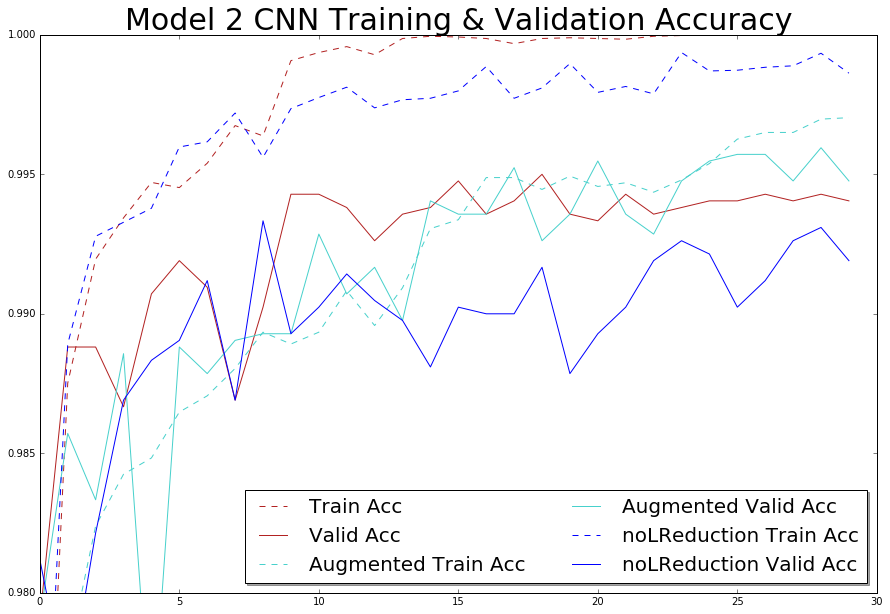

In [91]:
history3_wDaug = pickle.load( open( 'model3_history_30epochs_wDAug.p', 'rb'))
history3_noLRed = pickle.load( open( 'model3_history_30epochs_noLRred.p', 'rb'))
history3 = pickle.load( open( 'model3_history_30epochs.p', 'rb'))

# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.98)

plt.plot(history3['acc'], color='firebrick', linestyle='--', label="Train Acc")
plt.plot(history3['val_acc'], color='firebrick',label="Valid Acc")

plt.plot(history3_wDaug['acc'], color='mediumturquoise', linestyle='--', label="Augmented Train Acc")
plt.plot(history3_wDaug['val_acc'], color='mediumturquoise',label="Augmented Valid Acc")

plt.plot(history3_noLRed['acc'], color='b', linestyle='--', label="noLReduction Train Acc")
plt.plot(history3_noLRed['val_acc'], color='b',label="noLReduction Valid Acc")

plt.title("Model 2 CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=2)

## CNN Model #4:

I tried adding BatchNormalization to the second model, between the convolution and activation layers. However, this did not really improve perfomance. 

Comparing the accuracy of these three models, model 4 exhibits similar behavior of model 2 & 4 -- more overfitting but ultimately has more volatily validation scores. 

**Without data augmentation: After 30 epochs:** val_acc:  0.9902

In [86]:
model4 = Sequential()

model4.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 input_shape = (28,28,1)))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2,2)))

model4.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(MaxPool2D(strides=(2,2)))

model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(128, activation = "relu"))
model4.add(Dense(nb_classes, activation = "softmax"))

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_21 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
__________

In [88]:
# Define the optimizer & Compile the model
optimizer = "adam"
model4.compile(optimizer = optimizer , \
              loss = "categorical_crossentropy", \
              metrics=["accuracy"])

# Train Model & Pickle the Training History
history4 = model4.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),\
                                epochs = epochs, validation_data = (X_val,Y_val),\
                                verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,\
                                callbacks=[learning_rate_reduction])


Epoch 1/30
 - 89s - loss: 0.3314 - acc: 0.9032 - val_loss: 0.2299 - val_acc: 0.9281
Epoch 2/30
 - 87s - loss: 0.0912 - acc: 0.9712 - val_loss: 0.0879 - val_acc: 0.9729
Epoch 3/30
 - 87s - loss: 0.0706 - acc: 0.9783 - val_loss: 0.0453 - val_acc: 0.9860
Epoch 4/30
 - 87s - loss: 0.0580 - acc: 0.9822 - val_loss: 0.0372 - val_acc: 0.9893
Epoch 5/30
 - 87s - loss: 0.0531 - acc: 0.9840 - val_loss: 0.0417 - val_acc: 0.9869
Epoch 6/30
 - 87s - loss: 0.0488 - acc: 0.9849 - val_loss: 0.0879 - val_acc: 0.9693
Epoch 7/30
 - 87s - loss: 0.0442 - acc: 0.9866 - val_loss: 0.0348 - val_acc: 0.9886

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 8/30
 - 87s - loss: 0.0291 - acc: 0.9909 - val_loss: 0.0265 - val_acc: 0.9924
Epoch 9/30
 - 87s - loss: 0.0303 - acc: 0.9906 - val_loss: 0.0252 - val_acc: 0.9926
Epoch 10/30
 - 87s - loss: 0.0265 - acc: 0.9921 - val_loss: 0.0226 - val_acc: 0.9921
Epoch 11/30
 - 87s - loss: 0.0255 - acc: 0.9921 - val_loss: 0.0307 - val_acc: 0.99

In [89]:
with open('model4_history_30epochs_wDAug.p', 'wb') as file_pi:
    pickle.dump(history4.history, file_pi)

In [93]:
history4_wDaug = pickle.load( open( 'model4_history_30epochs_wDAug.p', 'rb'))
# history4 = pickle.load( open( 'model4_history_30epochs.p', 'rb'))

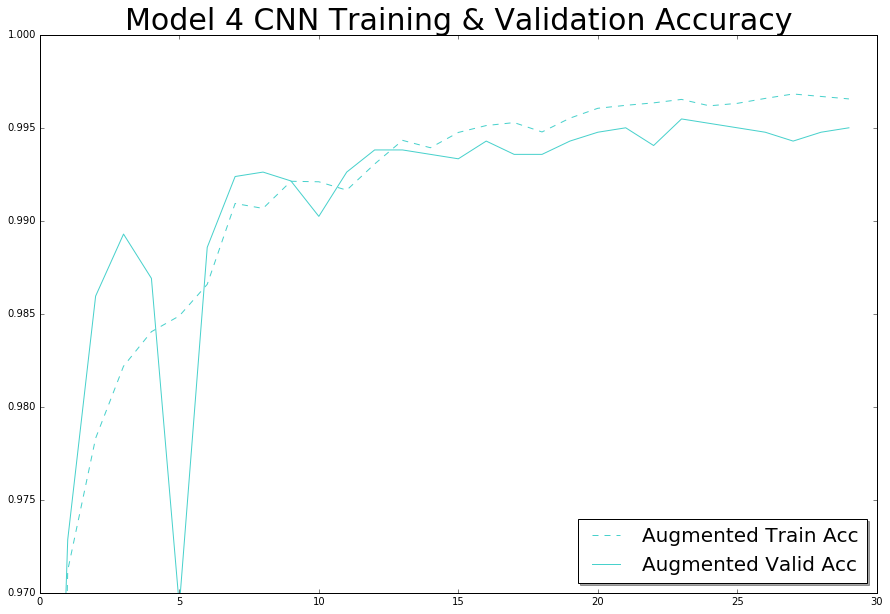

In [94]:
# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.97)

# plt.plot(history4['acc'], color='firebrick', linestyle='--', label="Train Acc")
# plt.plot(history4['val_acc'], color='firebrick',label="Valid Acc")

plt.plot(history4_wDaug['acc'], color='mediumturquoise', linestyle='--', label="Augmented Train Acc")
plt.plot(history4_wDaug['val_acc'], color='mediumturquoise',label="Augmented Valid Acc")

plt.title("Model 4 CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True)

# Compare all 4 wDataAug models

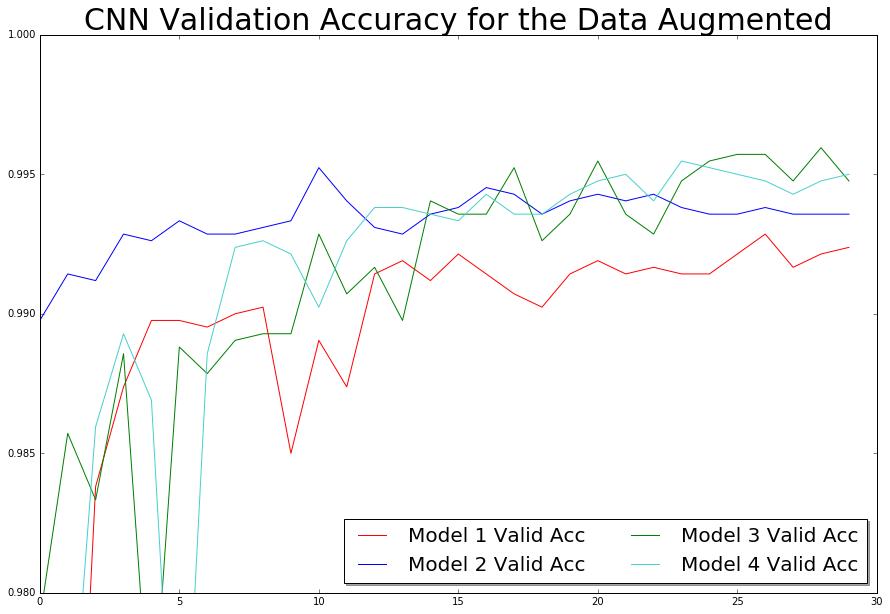

In [97]:

# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.98)


plt.plot(history1_wDaug['val_acc'], color='r',label="Model 1 Valid Acc")
plt.plot(history2_wDaug['val_acc'], color='b',label="Model 2 Valid Acc")
plt.plot(history3_wDaug['val_acc'], color='g',label="Model 3 Valid Acc")
plt.plot(history4_wDaug['val_acc'], color='mediumturquoise',label="Model 4 Valid Acc")


plt.title("CNN Validation Accuracy for the Data Augmented", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=2)